
# 05 — Rough Variance (Volterra) — Minimal Reference Simulation

This notebook implements a **reference** rough-variance simulation. I use the **direct Volterra** discretization with **cell-averaged kernel weights** (cost $O(N^2)$ per path). I will use this as a baseline to validate a **sum-of-exponentials (SoE) / Markovianized** variant. The notebook also **plots sample paths** and the **terminal histogram**.


In [3]:

import numpy as np
import math
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True)


## Rough fOU Variance Representation

For a rough fOU / rough-Heston-type variance process, we model the variance path $v_{t_i}$ as:

$$
v_{t_i}
= v_0
+ \underbrace{\int_0^{t_i} K(t_i-s)\,\phi(s)\,ds}_{\text{deterministic Volterra integral}}
+ \underbrace{\int_0^{t_i} K(t_i-s)\,\psi(s)\,dW_s}_{\text{stochastic Volterra integral}}
$$

where the kernel is:

$$
K(t) = \frac{t^{H-\tfrac{1}{2}}}{\Gamma(H+\tfrac{1}{2})}, 
\quad \text{(singular at $t=0$ for $H < \tfrac12$)}
$$

with:
- $\phi(s) = \kappa(\theta - v_s)$ — deterministic mean-reverting drift  
- $\psi(s) = \xi\sqrt{v_s}$ — stochastic volatility-of-volatility  




We discretize both integrals cell-by-cell over a uniform time grid using a Riemann–Stieltjes approach.
- $H$ controls roughness (smaller $H$ = rougher, longer memory).
- Units: $t$ is time on the simulation grid; $K$ is evaluated either via exact **cell integrals** (for the $ds$ part) or at **cell midpoints** (for the $dW$ part).

We precompute two sequences of weights for a uniform grid with step $dt$ and $n\_steps$ steps:
- $w^{(dt)}$: exact cell integrals of $K$ for the $ds$-integral.
- $w^{(dW)}$: $K$ evaluated at cell midpoints for the $dW$-integral.



## Weights (clear split)

We work on a uniform grid $t_i = i\,dt$ and define the lag $n := i - m$.

**Deterministic (ds) weight — exact cell average (used in the code):**
$$
w^{(dt)}_{n}
= \int_{(n-1)\,dt}^{n\,dt} K(u)\,du
= \frac{(n\,dt)^{H+\tfrac12}-\big((n-1)\,dt\big)^{H+\tfrac12}}
{\Gamma\!\left(H+\tfrac12\right)\,\left(H+\tfrac12\right)}.
$$

**Stochastic (dW) weight — midpoint:**
$$
w^{(dW)}_{n} \approx K\!\big((n-\tfrac12)\,dt\big)
= \frac{\big((n-\tfrac12)\,dt\big)^{H-\tfrac12}}{\Gamma\!\left(H+\tfrac12\right)}.
$$

We then write the Volterra terms at $t_i$ as causal convolutions:
$$
\sum_{m=0}^{i-1} w^{(dt)}_{\,i-m}\,\phi_m
\quad\text{and}\quad
\sum_{m=0}^{i-1} w^{(dW)}_{\,i-m}\,\psi_m\,\Delta W_m,
$$
with $\phi_m=\kappa(\theta - v_{t_m})$ and $\psi_m=\xi\sqrt{v_{t_m}}$.


In [4]:

def K_power(t: np.ndarray, H: float) -> np.ndarray:
    # Kernel K(t) = t**(H - 0.5) / Gamma(H + 0.5)
    return np.power(t, H - 0.5) / math.gamma(H + 0.5)

def precompute_weights(n_steps: int, dt: float, H: float):
    # Lag midpoints and dW weights: K((n - 0.5) * dt)
    n = np.arange(1, n_steps + 1)
    t_mid = (n - 0.5) * dt
    w_dW_mid = K_power(t_mid, H)
    # Exact dt weights over [(n-1)*dt, n*dt]
    Hp = H + 0.5
    t_right = n * dt
    t_left  = (n - 1) * dt
    w_dt_exact = ( (t_right ** Hp) - (t_left ** Hp) ) / (math.gamma(H + 0.5) * Hp)
    return w_dt_exact, w_dW_mid


In [5]:

def simulate_variance_direct(n_paths: int, n_steps: int, T: float,
                             v0: float, kappa: float, theta: float, xi: float, H: float,
                             seed: int = 1):
    # Direct Volterra simulation (O(n_steps^2) per path). Returns t (grid) and v (paths).
    rng = np.random.default_rng(seed)

    # Time step and kernel weights
    dt = T / n_steps
    w_dt, w_dW = precompute_weights(n_steps, dt, H)

    # Storage
    v = np.full((n_paths, n_steps + 1), v0, dtype=float)
    dW = rng.standard_normal(size=(n_paths, n_steps)) * np.sqrt(dt)

    for i in range(1, n_steps + 1):
        # Weights aligned by lag (reverse so lag 1 is most recent)
        wdti = w_dt[:i][::-1]   # [w_dt[i], w_dt[i-1], ..., w_dt[1]]
        wdWi = w_dW[:i][::-1]   # [w_dW[i],..., w_dW[1]]

        # Integrands over past cells
        phi = kappa * (theta - v[:, :i])    # [phi_0, ..., phi_{i-1}]                 
        psi = xi * np.sqrt(np.maximum(v[:, :i], 0.0))    # [psi_0, ..., psi_{i-1}]

        # Volterra sums (casual convolution)
        term_dt = (phi * wdti).sum(axis=1)                # ds integral
        term_dW = (psi * dW[:, :i] * wdWi).sum(axis=1)    # dW integral

        # Update and floor
        v[:, i] = v0 + term_dt + term_dW
        v[:, i] = np.maximum(v[:, i], 1e-12)

    t = np.linspace(0.0, T, n_steps + 1)
    return t, v



## Demo: plot paths and terminal histogram


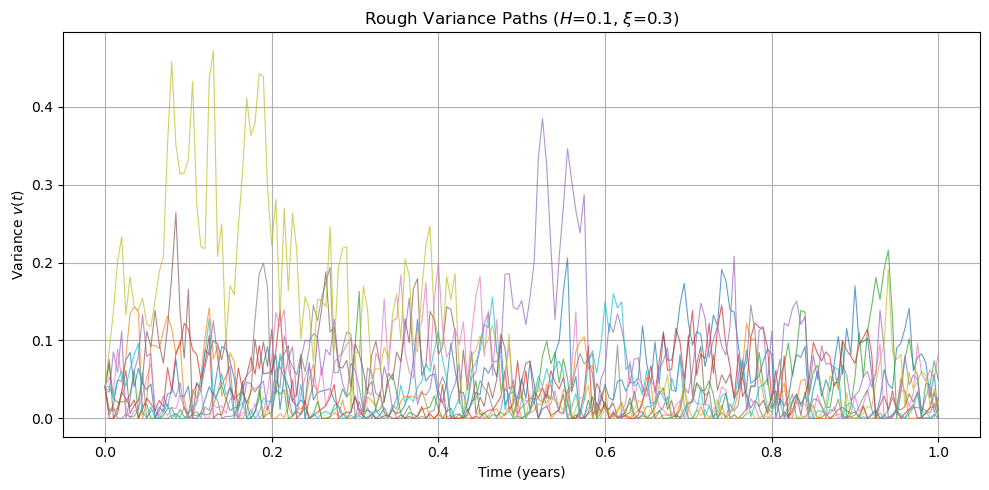

In [6]:

# Parameters (keep moderate — O(n_steps^2))
n_paths = 1500
n_steps = 200
T = 1.0
v0 = 0.04
kappa, theta, xi = 1.5, 0.04, 0.3
H = 0.1

t, v = simulate_variance_direct(n_paths, n_steps, T, v0, kappa, theta, xi, H, seed=123)

# Plot variance paths (consistent style)
n_plot = 10

plt.figure(figsize=(10, 5))
for j in range(min(n_plot, n_paths)):
    plt.plot(t, v[j], lw=0.8, alpha=0.7)
plt.title(rf"Rough Variance Paths ($H$={H}, $\xi$={xi})")
plt.xlabel("Time (years)")
plt.ylabel("Variance $v(t)$")
plt.grid(True)
plt.tight_layout()
plt.show()

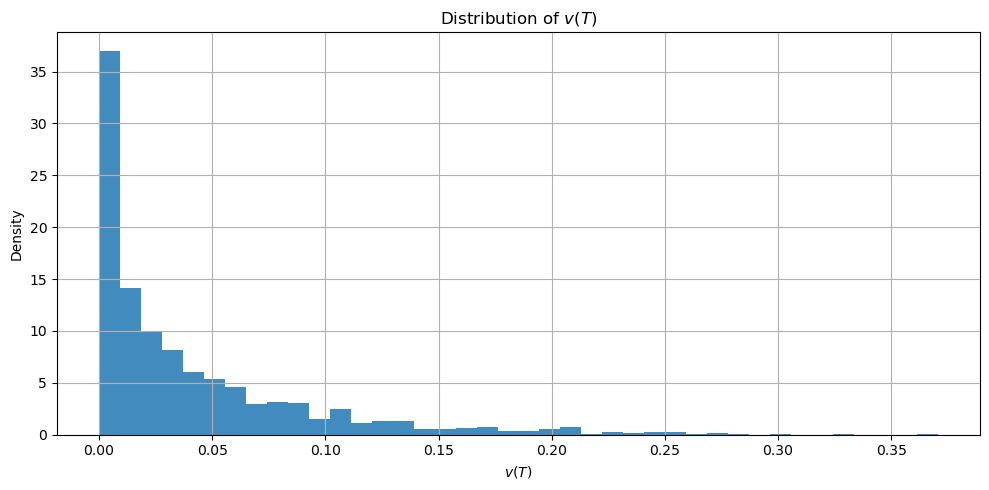

In [7]:
# terminal histogram at maturity
plt.figure(figsize=(10, 5))
plt.hist(v[:, -1], bins=40, density=True, alpha=0.85)
plt.title(r"Distribution of $v(T)$")
plt.xlabel(r"$v(T)$")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np

mean = v[:, -1].mean()
median = np.median(v[:, -1])
q95 = np.quantile(v[:, -1], 0.95)
tail = (v[:, -1] > 0.20).mean()  # fraction above 20% variance

print(f"mean={mean:.4f}, median={median:.4f}, 95%={q95:.4f}, P[v(T)>0.20]={tail:.3%}")

mean=0.0403, median=0.0211, 95%=0.1477, P[v(T)>0.20]=2.267%


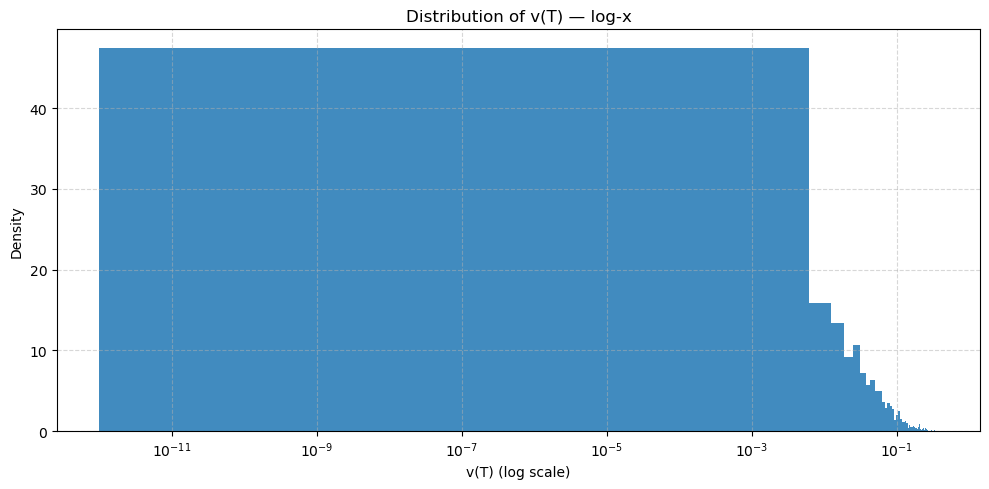

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(v[:, -1], bins=60, density=True, alpha=0.85)
plt.xscale('log')
plt.xlabel("v(T) (log scale)")
plt.ylabel("Density")
plt.title("Distribution of v(T) — log-x")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [10]:
eps = 1e-12  # your floor
vT = v[:, -1]
frac_floor = (vT <= 1.001*eps).mean()
print(f"fraction at floor ≈ {frac_floor:.2%}")

fraction at floor ≈ 13.47%


### Interpretation — Terminal Variance Distribution

The histogram above shows the distribution of terminal variance $v(T)$ on a **logarithmic $x$-axis**.  
We observe:

- **Heavy mass near zero**: Most paths end with variance close to the floor value.  
- **Long right tail**: A minority of paths experience persistent high-volatility episodes, pushing $v(T)$ up to $10^{-1}$ or more.  
- **Strong skewness**: The log-scale makes visible the extreme asymmetry between low- and high-vol states.

**Why this happens in the rough fOU setting:**
1. **Singular Volterra kernel** $K(t) = t^{H - \frac12} / \Gamma\!\left(H + \frac12\right)$ with $H < 0.5$ magnifies short-time shocks.
2. **Weak mean reversion** when $\kappa$ is small allows variance to linger near zero.
3. **Flooring bias**: The lower bound $v \ge \varepsilon$ prevents negative variance but accumulates mass at the floor.
4. **Vol-of-vol $\xi$** controls tail thickness — larger $\xi$ increases probability of extreme variance spikes.

**Interview note:**  
In practice, such a skewed $v(T)$ distribution affects **forward-start option smiles** and the **pricing of barrier products**, where the likelihood of variance collapse vs. persistence directly impacts premiums.  
Calibration must balance $\xi$ and $\kappa$ to avoid excessive mass at zero while still fitting the steep short-dated skew.



## Optional: refinement check (weak convergence trend)


In [11]:

def terminal_mean(n_paths: int, n_steps: int, T: float, v0: float, kappa: float, theta: float, xi: float, H: float, seed: int):
    _, v = simulate_variance_direct(n_paths, n_steps, T, v0, kappa, theta, xi, H, seed=seed)
    return v[:, -1].mean()

mean_coarse = terminal_mean(1000, 150, T, v0, kappa, theta, xi, H, seed=7)
mean_fine   = terminal_mean(1000, 300, T, v0, kappa, theta, xi, H, seed=7)
print("Mean v(T) coarse n_steps=150:", round(mean_coarse, 6))
print("Mean v(T)   fine n_steps=300:", round(mean_fine,   6))
print("Relative change:", round((mean_fine/mean_coarse) - 1.0, 6))


Mean v(T) coarse n_steps=150: 0.042564
Mean v(T)   fine n_steps=300: 0.042362
Relative change: -0.004746



## Timing: empirical scaling

I time the reference simulator to show its scaling:
- vs. `n_steps` (should be ~quadratic per path),
- vs. `n_paths` (should be ~linear).


Scaling vs n_steps (n_paths = 256):
  n_steps= 100  time=0.064s
  n_steps= 150  time=0.076s
  n_steps= 200  time=0.120s
  n_steps= 300  time=0.269s
  n_steps= 400  time=0.427s


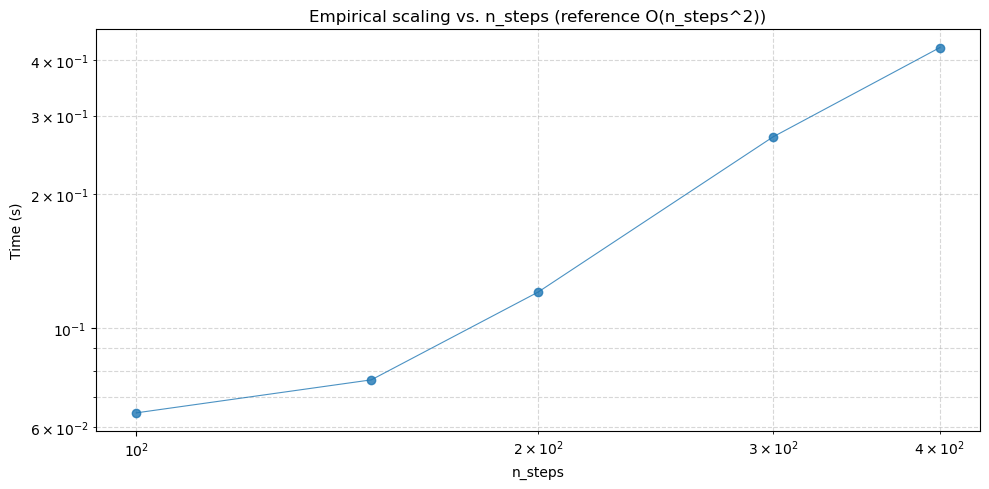


Scaling vs n_paths (n_steps = 200):
  n_paths= 256  time=0.121s
  n_paths= 512  time=0.326s
  n_paths=1024  time=0.732s


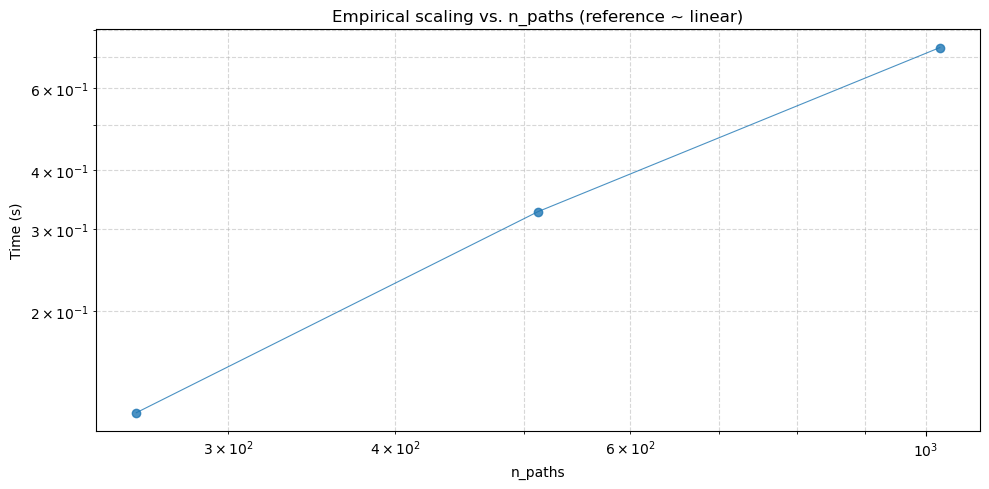

In [11]:

import time
import numpy as np
import matplotlib.pyplot as plt

# Fixed parameters
T = 1.0
v0 = 0.04
kappa, theta, xi = 1.5, 0.04, 0.3
H = 0.1
seed = 11

# Scaling vs n_steps (quadratic per path)
n_paths = 256
grid_steps = [100, 150, 200, 300, 400]
times_steps = []
for ns in grid_steps:
    t0 = time.perf_counter()
    _t, _v = simulate_variance_direct(n_paths, ns, T, v0, kappa, theta, xi, H, seed=seed)
    times_steps.append(time.perf_counter() - t0)
print("Scaling vs n_steps (n_paths = {}):".format(n_paths))
for ns, tt in zip(grid_steps, times_steps):
    print(f"  n_steps={ns:4d}  time={tt:.3f}s")

plt.figure(figsize=(10, 5))
plt.loglog(grid_steps, times_steps, marker="o", lw=0.8, alpha=0.8)
plt.xlabel("n_steps")
plt.ylabel("Time (s)")
plt.title("Empirical scaling vs. n_steps (reference O(n_steps^2))")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Scaling vs n_paths (linear at fixed n_steps)
n_steps = 200
grid_paths = [256, 512, 1024]
times_paths = []
for np_ in grid_paths:
    t0 = time.perf_counter()
    _t, _v = simulate_variance_direct(np_, n_steps, T, v0, kappa, theta, xi, H, seed=seed)
    times_paths.append(time.perf_counter() - t0)
print("\nScaling vs n_paths (n_steps = {}):".format(n_steps))
for np_, tt in zip(grid_paths, times_paths):
    print(f"  n_paths={np_:4d}  time={tt:.3f}s")

plt.figure(figsize=(10, 5))
plt.loglog(grid_paths, times_paths, marker="o", lw=0.8, alpha=0.8)
plt.xlabel("n_paths")
plt.ylabel("Time (s)")
plt.title("Empirical scaling vs. n_paths (reference ~ linear)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()
